In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

#from pandas_profiling import ProfileReport
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
#from fancyimpute import KNN
import seaborn as sns

In [2]:
churn = pd.read_csv('../data/churn.csv')
#Simple mean impute for ratings columns
imp = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imp.fit(churn[['avg_rating_by_driver','avg_rating_of_driver']])
churn_imp = imp.transform(churn[['avg_rating_by_driver','avg_rating_of_driver']])
pd.DataFrame(churn_imp)
churn[['avg_rating_by_driver','avg_rating_of_driver']]=churn_imp
churn#encode non-null values: https://towardsdatascience.com/preprocessing-encode-and-knn-impute-all-categorical-features-fast-b05f50b4dfaa 
encoder = OrdinalEncoder()
#imputer = KNN()
cat_cols = ['phone']


def encode(data):
    '''function to encode non-null data and replace it in the original data'''
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data 

for columns in cat_cols:
    
    encode(churn[columns])
    
def churn_(df, column):
    dates = df[column]
    cutoff_date = '2014-06-01'
    array = []
    for date in dates:
        if date > cutoff_date:
            array.append(1)
        else:
            array.append(0)
    df['active'] = array
    return df

churn = churn_(churn, 'last_trip_date')
    
#KNN impute for phone column
imputer = KNNImputer(n_neighbors=5, weights="uniform")
churn_imp2=imputer.fit_transform(churn[['avg_rating_by_driver','avg_rating_of_driver','phone']])
churn[['avg_rating_by_driver','avg_rating_of_driver','phone']]=churn_imp2# creating instance of one-hot-encoder 
enc = OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(churn[['city']]).toarray())
churn = churn.join(enc_df)
churn = churn.drop(['city'],axis =1)

#create feature with difference between signup and last trip
churn['last_trip_date_d'] = pd.to_datetime(churn['last_trip_date'])
churn['signup_date_d'] = pd.to_datetime(churn['signup_date'])
churn['date_delta'] = churn['last_trip_date_d']-churn['signup_date_d']
churn = churn.rename(columns = {0:'city_0', 1:'city_1',2:'city_2'},errors = 'raise')

def date_to_month(df, column_name):
    df[column_name] = pd.to_datetime(df[column_name])
    df['month '+ column_name] = df[column_name].dt.month
    return df

date_to_month(churn, 'signup_date')

churn = churn.drop(['signup_date'],axis =1)
date_to_month(churn, 'last_trip_date')
churn = churn.drop(['last_trip_date'], axis = 1)
churn = churn.drop(['last_trip_date_d'], axis = 1)
churn = churn.drop(['signup_date_d'], axis = 1)
# churn = churn.drop(['month_signup_date'], axis = 1)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [3]:
churn.columns

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'phone', 'surge_pct', 'trips_in_first_30_days', 'luxury_car_user',
       'weekday_pct', 'active', 'city_0', 'city_1', 'city_2', 'date_delta',
       'month signup_date', 'month last_trip_date'],
      dtype='object')

In [4]:
churn['date_delta'] = churn['date_delta'].dt.days

In [5]:
churn.drop(columns=['date_delta', 'month last_trip_date'], inplace=True)

In [6]:
X = churn
y = churn.pop('active')


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=1)


In [48]:
gdbr = GradientBoostingClassifier(learning_rate=.10,
                                  loss='deviance',
                                  n_estimators=200,
                                  random_state=1,
                                  min_samples_split = 4,
                                  max_depth=6)





In [49]:
gdbr.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=6, min_samples_split=4, n_estimators=200,
                           random_state=1)

In [50]:
gdbr.score(X_test, y_test)

0.7947

In [ ]:
np.mean(gdbr.train_score_)

In [60]:
X.columns

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'phone', 'surge_pct', 'trips_in_first_30_days', 'luxury_car_user',
       'weekday_pct', 'city_0', 'city_1', 'city_2', 'month signup_date'],
      dtype='object')

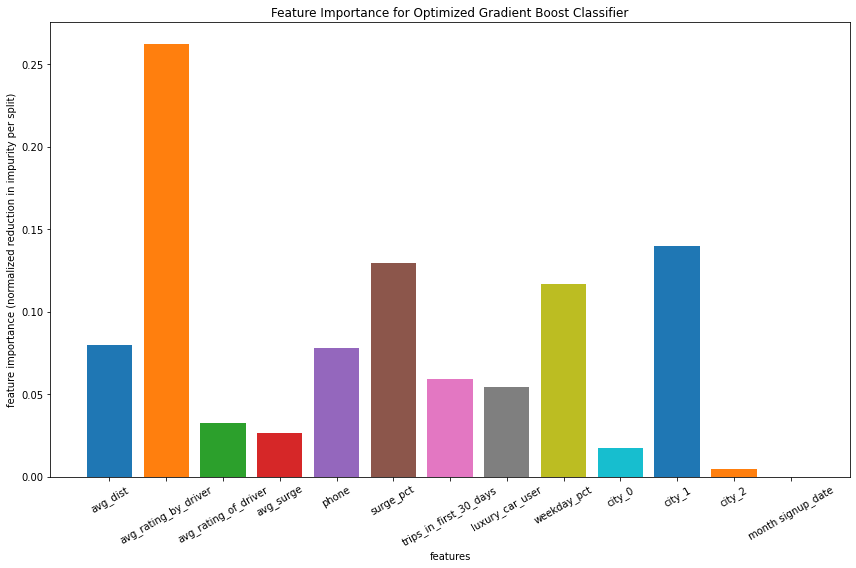

In [64]:
fig, ax = plt.subplots(figsize=(12,8))
for i,n in enumerate(X.columns):
    ax.bar(n, gdbr.feature_importances_[i])
ax.set_xlabel('features')
ax.set_ylabel('feature importance (normalized reduction in impurity per split)')
ax.set_title('Feature Importance for Optimized Gradient Boost Classifier')
plt.xticks(rotation = 30)
plt.tight_layout()

In [26]:
def get_scores_v_n_est(model, y_test ):
    scores = [mean_squared_error(y_test, predict) for predict in model.staged_predict(X_test)]
    return scores

best number of estimators is 54


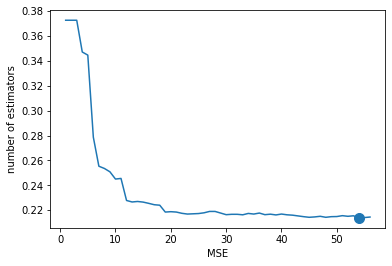

In [38]:
scores = get_scores_v_n_est(gdbr, y_test )
fig,ax = plt.subplots()
ax.plot(np.arange(len(scores))+1,scores)
ax.scatter(np.argmin(scores)+1, scores[np.argmin(scores)], s=100)
ax.set_ylabel('number of estimators')
ax.set_xlabel('MSE')
print('best number of estimators is {}'.format(np.argmin(scores)+1) )

In [41]:


grid = {'max_depth': [2,4,6],
        'min_samples_split': [ 2, 4, 8]}

gb_gridsearch = GridSearchCV(estimator=gdbr, param_grid=grid, 
                             cv=5, verbose=0, return_train_score=True,
                            n_jobs = -1)

gb_gridsearch.fit(X_train, y_train)

# and after some hours...
df_gridsearch = pd.DataFrame(gb_gridsearch.cv_results_)


In [42]:
max_scores = df_gridsearch.groupby(['param_max_depth', 
                                    'param_min_samples_split']).max()  # it doesnt matter what this is, there is only one value

max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]

max_scores



mean_test_score                     mean_train_score  \
param_min_samples_split               2         4         8                2   
param_max_depth                                                                
2                              0.781500  0.781500  0.781500         0.782525   
4                              0.788850  0.788825  0.789125         0.795669   
6                              0.792225  0.793075  0.792125         0.811338   

                                             
param_min_samples_split         4         8  
param_max_depth                              
2                        0.782525  0.782525  
4                        0.795644  0.795894  
6                        0.811512  0.810887

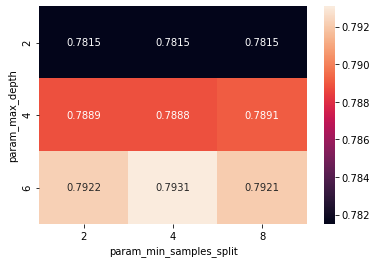

In [43]:
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

